<a href="https://colab.research.google.com/github/nadya-soto/Reinforcement-learning-2/blob/main/ConnectX_AI_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConnectX AI Agents

In this project we will use *Kaggle environments*, in particular this one [ConnectX](https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/connectx/connectx.ipynb).






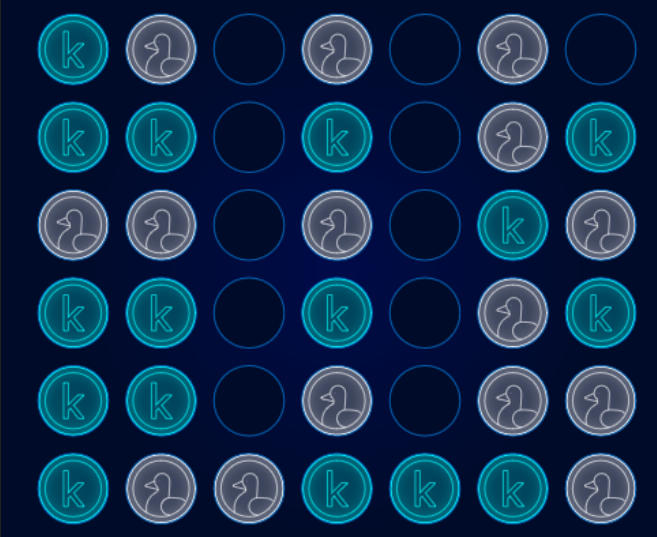

The first line of code install all the `kaggle environments`. If you want to install them locally (and not use Colab), it is the same line if you are using `Jupyter notebooks`.

There are certain advantages to such local installation: for example, training can be faster if you have a reasonable computer. Also, training against a `human player`, only works on local installations. There are of course advantages of using Colab instead (no need to install anything, you can use the lab computers...).

In [1]:
!pip install kaggle-environments --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We import the necessary libraries. (run the following cell twice).

In [2]:
from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 178, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 63, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

['random', 'negamax']


## Parameters
To make the training a bit easier (less time consuming) we will work on the case of a grid of `4x5` in which you aim to place `3` consecutive pieces (vertical, horizontal or diagonal).

In [3]:
rows = 4
columns = 5
in_a_row = 3
debug_mode = True


env = make("connectx", {"rows": rows, "columns": columns, "inarow": in_a_row}, steps=[], debug=debug_mode)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
import joblib
from kaggle_environments import make

# **My agent 1: Q-Learning**
---

In [5]:
class QLearningAgent:
    def __init__(self, rows, columns, in_a_row, alpha=1, epsilon=1, gamma=1, num_episodes=10000):
        self.rows = rows
        self.columns = columns
        self.in_a_row = in_a_row
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.nA = columns  # Number of possible actions
        self.nS = rows * columns  # Number of possible states
        self.Q = defaultdict(self.init_Q_values)  # Initialize empty dictionary to store Q-values
        self.state_key = None  # Current state
        self.next_state_key = None  # Next state

    # Function to initialize Q-values
    def init_Q_values(self):
        return np.zeros(self.nA)

    def act(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.nA)
        else:
            state_key = tuple(observation.board)
            return np.argmax(self.Q[state_key])

    def learn(self, observation, action, reward, next_observation):
        if reward is None or not isinstance(reward, (int, float)):
            reward = 0

        self.state_key = tuple(observation.board)
        self.next_state_key = tuple(next_observation.board)
        td_target = reward + self.gamma * np.max(self.Q[self.next_state_key])
        td_error = td_target - self.Q[self.state_key][action]
        self.Q[self.state_key][action] += self.alpha * td_error


In [6]:
def train_agent(env, agent, num_episodes, save_path=None):
    wins = 0
    invalid = 0

    for _ in tqdm(range(num_episodes)):
        obs = env.reset()
        done = False
        while not done:
            action = agent.act(obs)
            new_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, new_obs)
            obs = new_obs

        if done:
            obs = env.reset()
            if reward == 1:
                wins += 1
            if reward != 1 and reward != -1:
                invalid += 1

    win_percentage = (wins / (num_episodes - invalid)) * 100
    print("Percentage of games won:", win_percentage)

    # Save the agent if a save path is provided
    if save_path:
        joblib.dump(agent, save_path)
        print("Learning saved at:", save_path)

In [7]:
# Create the Q-Learning agent
my_agent1 = QLearningAgent(rows, columns, in_a_row)


trainer1 = env.train([None, "random"]) # Set up the environment trainer

train_agent(trainer1, my_agent1, num_episodes=100, save_path='q_learning_agent1.pkl') # Train the agent using Q-Learning


  0%|          | 0/100 [00:00<?, ?it/s]

Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 4
Percentage of games won: 63.85542168674698
Learning saved at: q_learning_agent1.pkl


In [8]:
def trained_policy(observation, agent):
    return agent.act(observation)

Let's try it out:

In [9]:
obs = env.reset()  # Get the initial observation
action = trained_policy(obs, my_agent1)

# Define a wrapper function for trained_policy that links to the specific agent
def call_agent_1(observation, configuration):
    return trained_policy(observation, my_agent1)

# Run a game with the trained policy against a random opponent
env.run([call_agent_1, 'random'])
env.render(mode="ipython")  # Show the game

# Print the reward obtained during the game
print(env.state[0].reward)


1


In [10]:
trainer2 = env.train([None, "negamax"])

train_agent(trainer2, my_agent1, num_episodes=100, save_path='q_learning_agent2.pkl')


  0%|          | 0/100 [00:00<?, ?it/s]

Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Percentage of games won: 3.1914893617021276
Learning saved at: q_learning_agent2.pkl


In [11]:
obs = env.reset()  # Get the initial observation
action2 = trained_policy(obs, my_agent1)

# Define a wrapper function for trained_policy that links to the specific agent
def trained_policy_wrapper(observation, configuration):
    return trained_policy(observation, my_agent1)

# Run a game with the trained policy against a random opponent
env.run([trained_policy_wrapper, 'random'])
env.render(mode="ipython")  # Display the game

# Print the reward obtained during the game
print(env.state[0].reward)

1


It's very bad against negamax


# **My agent 2: Sarsa(λ)**

---



In [12]:
class SarsaLambdaAgent:
    def __init__(self, rows, columns, in_a_row, epsilon=0.5, alpha=0.1, gamma=0.9, lmbda=0.5):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.lmbda = lmbda
        self.columns = columns
        self.weights = np.random.rand(rows * columns)  # Initialize weights with appropriate length
        self.eligibility_trace = np.zeros(rows * columns)  # Initialize eligibility trace

    def act(self, obs):
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.columns))  # Return random move
        else:
            valid_moves = [col for col in range(self.columns) if obs.board[col] == 0]
            state_features = np.array(obs.board)
            action_values = np.dot(self.weights, state_features)
            if np.isscalar(action_values):  # Handle scalar case
                return valid_moves[0]  # Return the first valid move
            else:
                return int(valid_moves[np.argmax(action_values[valid_moves])])  # Convert action to integer

    def learn(self, obs, action, reward, next_obs):
        if reward is None:
            reward = 0  # Set reward to 0 if it's None
        state_key = tuple(obs.board)
        next_state_key = tuple(next_obs.board)
        td_error = reward + self.gamma * np.dot(self.weights, next_obs.board) - np.dot(self.weights, obs.board)
        self.eligibility_trace = self.gamma * self.lmbda * self.eligibility_trace + obs.board
        self.weights += self.alpha * td_error * self.eligibility_trace
        self.epsilon *= 0.6  # Decay epsilon


In [13]:
def train_SarsaLambda_agent(env, agent, num_episodes, load_path=None, save_path=None):
    if load_path:
        agent.weights = np.load(load_path)
    wins = 0
    total_rewards = np.zeros(num_episodes)
    invalid = 0

    for iEpisode in tqdm(range(num_episodes), position=0, leave=True):
        obs = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.act(obs)
            new_obs, reward, done, _ = env.step(action)

            if reward is None:
                # The action was invalid, no reward
                invalid += 1
                break

            agent.learn(obs, action, reward, new_obs)
            episode_reward += reward
            obs = new_obs

        total_rewards[iEpisode] = episode_reward

        if episode_reward == 1:
            wins += 1

    win_percentage = (wins / (num_episodes - invalid)) * 100
    print("Percentage of games won:", win_percentage)

    # Save the agent if a save path is provided
    if save_path:
        np.save(save_path, agent.weights)
        print("Learning saved at:", save_path)

    return total_rewards


In [14]:
# Create the Q-Learning agent
my_agent2 = SarsaLambdaAgent(rows, columns, in_a_row)

trainer1 = env.train([None, "random"])

train_SarsaLambda_agent(trainer1, my_agent2, num_episodes=100, save_path='SarsaLambdaAgent')


  0%|          | 0/100 [00:00<?, ?it/s]

Invalid Action: 0 is not of type 'integer'

Failed validating 'type' in schema:
    {'description': 'Column to drop a checker onto the board.',
     'type': 'integer',
     'default': 0,
     'minimum': 0}

On instance:
    0
Invalid Action: 2 is not of type 'integer'

Failed validating 'type' in schema:
    {'description': 'Column to drop a checker onto the board.',
     'type': 'integer',
     'default': 0,
     'minimum': 0}

On instance:
    2
Invalid Action: 2 is not of type 'integer'

Failed validating 'type' in schema:
    {'description': 'Column to drop a checker onto the board.',
     'type': 'integer',
     'default': 0,
     'minimum': 0}

On instance:
    2
Invalid Action: 3 is not of type 'integer'

Failed validating 'type' in schema:
    {'description': 'Column to drop a checker onto the board.',
     'type': 'integer',
     'default': 0,
     'minimum': 0}

On instance:
    3
Invalid Action: 2 is not of type 'integer'

Failed validating 'type' in schema:
    {'descriptio

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [15]:
# Define a function for the agent to play against the ConnectX environment
def call_agent_2(observation, configuration):
    return my_agent2.act(observation)

# Run a game with the trained agent against a random opponent
env.run([call_agent_2, "random"])

# Display the game
env.render(mode="ipython")

# Print the reward obtained during the game
print("Game reward:", env.state[0].reward)


Game reward: 1


que pasa si random empieza primero

In [16]:
# Define a function for the agent to play against the ConnectX environment
def call_agent_2(observation, configuration):
    return my_agent2.act(observation)

# Run a game with the trained agent against a random opponent
env.run(["random", call_agent_2])

# Display the game
env.render(mode="ipython")

# Print the reward obtained during the game
print("Game reward:", env.state[0].reward)


Game reward: -1


Train it against randomax.

In [17]:
# Crear el agente Q-Learning
my_agent2 = SarsaLambdaAgent(rows, columns, in_a_row)


trainer12 = env.train([None, "negamax"])

train_SarsaLambda_agent(trainer12, my_agent2, num_episodes=100, load_path='SarsaLambdaAgent.npy',  save_path='SarsaLambdaAgent_negamax')


  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of games won: 0.0
Learning saved at: SarsaLambdaAgent_negamax


array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [18]:
#Run a game with the trained agent against a negamax opponent

env.run(["negamax", call_agent_2])
#Display the game

env.render(mode="ipython")
print("Game reward:", env.state[0].reward)

Game reward: 1


In [19]:
#Run a game with agent1 vs agent2

env.run([call_agent_1, call_agent_2])
#Display the game

env.render(mode="ipython")
print("Game reward:", env.state[0].reward)

Game reward: 1


In [20]:
num_games = 10
wins_agent_1 = 0
wins_agent_2 = 0

for _ in range(num_games):
    env.reset()  # Reset the environment for each game

    # Run the game with agents 1 and 2
    env.run([call_agent_1, call_agent_2])

    # Calculate the game reward and determine the winner
    reward = env.state[0].reward
    if reward == 1:
        wins_agent_1 += 1
    elif reward == -1:
        wins_agent_2 += 1

# Calculate the win percentages
win_percentage_agent_1 = (wins_agent_1 / num_games) * 100
win_percentage_agent_2 = (wins_agent_2 / num_games) * 100

# Display the results
print("Number of games:", num_games)
print("Wins of agent 1:", wins_agent_1, "(", win_percentage_agent_1, "%)")
print("Wins of agent 2:", wins_agent_2, "(", win_percentage_agent_2, "%)")

Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Number of games: 10
Wins of agent 1: 2 ( 20.0 %)
Wins of agent 2: 6 ( 60.0 %)


In [21]:
num_games = 100
wins_agent_1 = 0
wins_agent_2 = 0

for _ in range(num_games):
    env.reset()  # Reset the environment for each game

    # Run the game with agents 1 and 2
    env.run([call_agent_1, call_agent_2])

    # Calculate the game reward and determine the winner
    reward = env.state[0].reward
    if reward == 1:
        wins_agent_1 += 1
    elif reward == -1:
        wins_agent_2 += 1

# Calculate the win percentages
win_percentage_agent_1 = (wins_agent_1 / num_games) * 100
win_percentage_agent_2 = (wins_agent_2 / num_games) * 100

# Display the results
print("Number of games:", num_games)
print("Wins of agent 1:", wins_agent_1, "(", win_percentage_agent_1, "%)")
print("Wins of agent 2:", wins_agent_2, "(", win_percentage_agent_2, "%)")

Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Number of games: 100
Wins of agent 1: 32 ( 32.0 %)
Wins of agent 2: 55 ( 55.00000000000001 %)


In [22]:
num_games = 1000
wins_agent_1 = 0
wins_agent_2 = 0

for _ in range(num_games):
    env.reset()  # Reset the environment for each game

    # Run the game with agents 1 and 2
    env.run([call_agent_1, call_agent_2])

    # Calculate the game reward and determine the winner
    reward = env.state[0].reward
    if reward == 1:
        wins_agent_1 += 1
    elif reward == -1:
        wins_agent_2 += 1

# Calculate the win percentages
win_percentage_agent_1 = (wins_agent_1 / num_games) * 100
win_percentage_agent_2 = (wins_agent_2 / num_games) * 100

# Display the results
print("Number of games:", num_games)
print("Wins of agent 1:", wins_agent_1, "(", win_percentage_agent_1, "%)")
print("Wins of agent 2:", wins_agent_2, "(", win_percentage_agent_2, "%)")

Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action

# **My agent 3: REINFORCE-with-Baseline: Monte-Carlo Policy Gradient**



---



In [23]:

class ReinforceWithBaselineAgent:
    def __init__(self, observation_space, action_space, gamma=0.99, alpha_w=0.001, alpha_theta=0.001):
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma
        self.alpha_w = alpha_w
        self.alpha_theta = alpha_theta
        self.w = np.random.rand(observation_space.shape[0])  # Weights for the state-value function
        self.theta = np.random.rand(observation_space.shape[0], action_space.n)  # Weights for the policy
        self.grad_theta = np.zeros_like(self.theta)  # Gradient of policy weights
        self.grad_w = np.zeros_like(self.w)  # Gradient of state-value weights

    def act(self, observation):
        logits = np.dot(observation, self.theta)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        action = np.random.choice(self.action_space.n, p=probs)
        return action

    def learn(self, episode):
        states, actions, rewards = zip(*episode)
        T = len(states)
        G = 0
        for t in range(T - 1, -1, -1):
            G = self.gamma * G + rewards[t]
            state = states[t]
            action = actions[t]
            baseline = np.dot(state, self.w)
            pi = np.exp(np.dot(state, self.theta)) / np.sum(np.exp(np.dot(state, self.theta)))
            grad_ln_pi = np.zeros_like(self.theta)
            grad_ln_pi[:, action] = state / pi[action]
            self.grad_theta += self.gamma**t * (G - baseline) * grad_ln_pi
            self.grad_w += self.gamma**t * (G - baseline) * state
        self.theta += self.alpha_theta * self.grad_theta / T
        self.w += self.alpha_w * self.grad_w / T
        self.grad_theta = np.zeros_like(self.theta)
        self.grad_w = np.zeros_like(self.w)

In [24]:
def train_reinforce_baseline(env, agent, num_episodes):
    total_rewards = []
    for _ in tqdm(range(num_episodes)):
        episode = []
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(obs)
            new_obs, reward, done, _ = env.step(action)
            episode.append((obs, action, reward))
            obs = new_obs
            total_reward += reward
        agent.learn(episode)
        total_rewards.append(total_reward)
    return total_rewards